## Eigen-portfolio construction using Principal Component Analysis (PCA)¶

PCA via sklearn.decomposition using S&P 500 Index stock data

Welcome to your first assignment in Unsupervised Machine Learning in Finance.

In this assignment we look in-depth at model-free factor analysis using PCA. By model-free we mean that we do not rely on any factors such as value or momentum to decompose portfolio returns, but instead using Principal Component Analysis (PCA) to deduce structure of portfolio returns.

We work with S&P 500 index stock data.

Please read the attached article by Avellaneda and Lee which can also be found at: http://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf


## General Instructions¶

You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook.

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [1]:
import os
import os.path
import numpy as np
import datetime

import sys
sys.path.append("..")
# import grading

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass

try:
    import pandas as pd
    print("  pandas: %s"% pd.__version__)
except:
    print("Missing pandas package")

  pandas: 1.1.3


### Part 0 : Read Data¶
Instruction:
Please fill the '####' to read the data of spx_holdings_and_spx_closeprice.csv

In [2]:
# load dataset
asset_prices = pd.read_csv('spx_holdings_and_spx_closeprice.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
n_stocks_show = 15
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

Asset prices shape (3493, 419)


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AGN
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,32.9375,33.5625,37.9375,20.5938,39.688
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,32.3125,33.0000,38.1875,21.0000,40.250
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,32.5625,33.5000,40.0625,21.7188,40.313
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,32.5625,33.6875,40.3750,22.1563,41.375
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,32.5625,33.6250,39.6563,22.1875,42.813


In [3]:
print('Last column contains SPX index prices:')
asset_prices.iloc[:, -10:].head()

Last column contains SPX index prices:


,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-27,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12


### Part 1 (Asset Returns Calculation)¶
Instructions:

Calculate percent returns, also known as simple returns using asset_prices. assign the result to variable asset_returns. Keep only not-nan values in the resulting pandas.DataFrame

Calculate de-meaned returns and scale them by standard deviation  𝜎 . Assign result to normed_returns variable

We now compute stock returns and normalize stock returns data by subtracting the mean and dividing by standard diviation. This normalization is required by PCA.

In [4]:
asset_returns = pd.DataFrame(data=np.zeros(shape=(len(asset_prices.index), asset_prices.shape[1])), 
                             columns=asset_prices.columns.values,
                             index=asset_prices.index)
normed_returns = asset_returns

asset_returns = asset_prices.pct_change()
asset_returns.dropna()
normed_returns = (asset_returns-asset_returns.mean())/asset_returns.std()

normed_returns.iloc[-5:, -10:].head()

,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2013-12-16,0.852722,0.965219,-1.168885,0.884751,0.095865,0.656639,0.180014,-0.238498,0.465047,0.467931
2013-12-17,0.275173,0.517307,-0.086106,-0.306213,0.589689,-0.118610,-0.549523,0.025268,-0.260013,-0.247921
2013-12-18,0.864485,0.509435,0.600714,1.210605,-0.190024,0.925461,0.756998,0.058428,0.952458,1.252703
2013-12-19,0.210069,0.399574,-0.100159,-0.757419,-0.208023,0.304913,-0.772205,1.544228,-0.167775,-0.056358
2013-12-20,0.827306,0.748420,0.372443,1.048113,0.264046,0.436874,0.320641,-0.740854,0.373717,0.353859


In [5]:
train_end = datetime.datetime(2012, 3, 26) 

df_train = None
df_test = None
df_raw_train = None
df_raw_test = None

df_train = normed_returns[normed_returns.index <= train_end].copy()
df_test = normed_returns[normed_returns.index > train_end].copy()

df_raw_train = asset_returns[asset_returns.index <= train_end].copy()
df_raw_test = asset_returns[asset_returns.index > train_end].copy()

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (3056, 419)
Test dataset: (437, 419)


Now we compute PCA using all available data. Once we do have PCA computed we fix variance explained at some number and see what is the smallest number of components needed to explain this variance.

### Part 2 (PCA fitting)¶
Instructions:

. Calculate covariance matrix using training data set, i.e. df_train for all assets. Assign results to cov_matrix.
. Calculate covariance matrix using training data set, i.e. df_raw_train for all assets. Assign results to cov_matrix_raw.
. Use scikit-learn PCA to fit PCA model to cov_matrix. Assign fitted model to pca

In [6]:
import sklearn.decomposition
import seaborn as sns

stock_tickers = normed_returns.columns.values[:-1]
assert 'SPX' not in stock_tickers, "By accident included SPX index"

n_tickers = len(stock_tickers)
pca = None
cov_matrix = pd.DataFrame(data=np.ones(shape=(n_tickers, n_tickers)), columns=stock_tickers)
cov_matrix_raw = cov_matrix

if df_train is not None and df_raw_train is not None:
    stock_tickers = asset_returns.columns.values[:-1]
    assert 'SPX' not in stock_tickers, "By accident included SPX index"

    cov_matrix = df_train[stock_tickers].cov()
    cov_matrix_raw = df_raw_train[stock_tickers].cov()
    
    pca = sklearn.decomposition.PCA()
    pca.fit(cov_matrix)
    
    ### END CODE HERE ###
    
    cov_raw_df = pd.DataFrame({'Variance': np.diag(cov_matrix_raw)}, index=stock_tickers)    
    # cumulative variance explained
    var_threshold = 0.8
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  # +1 due to zero based-arrays
    print('%d components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

4 components explain 80.00% of variance


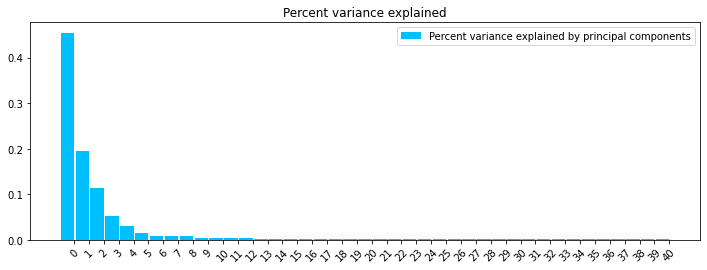

In [7]:
if pca is not None:
    bar_width = 0.9
    n_asset = int((1 / 10) * normed_returns.shape[1])
    x_indx = np.arange(n_asset)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    # Eigenvalues are measured as percentage of explained variance.
    rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color='deepskyblue')
    ax.set_xticks(x_indx + bar_width / 2)
    ax.set_xticklabels(list(range(n_asset)), rotation=45)
    ax.set_title('Percent variance explained')
    ax.legend((rects[0],), ('Percent variance explained by principal components',))

In [8]:
if pca is not None:
    projected = pca.fit_transform(cov_matrix)

### Part 3 (Eigen-portfolios construction)¶
Instructions:

We now look a the first two eigen portfolios. We use definition of eigen portfolios as provided by Avellaneda http://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf

Following Avellaneda we define eigen portfolio weights as:
𝑄(𝑗)𝑖=𝑣(𝑗)𝑖𝜎𝑖
 
where  𝑗  is the index of eigen portfolio and  𝑣𝑖  is the i-th element of j-th eigen vector.

In the code the pca.components_ are the Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.

Hint: do not forget to normalize portfolio wieghts such they sum up to 1.

Assign pc_w to be weights of the first eigen portfolio.

Sum of weights of first eigen-portfolio: 100.00


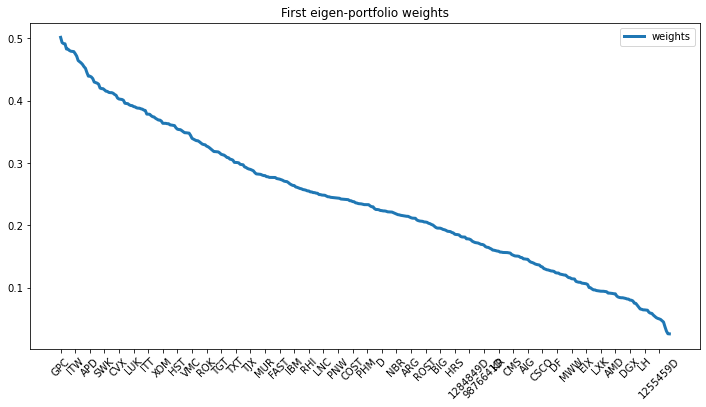

In [9]:
# the first two eigen-portfolio weights# the fi 
# first component
# get the Principal components
pc_w = np.zeros(len(stock_tickers))
eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
if pca is not None:
    pcs = pca.components_

    pc_w = pcs[0]/asset_returns.std()[0:len(asset_returns.std())-1]   
    pc_w = pc_w/(sum(pc_w))
    
    
    ### END CODE HERE ###
    
    eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of first eigen-portfolio: %.2f' % np.sum(eigen_prtf1))
    eigen_prtf1.plot(title='First eigen-portfolio weights', 
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

We sort the first two eigen portfolio weights and plot the results.

Sum of weights of second eigen-portfolio: 100.00


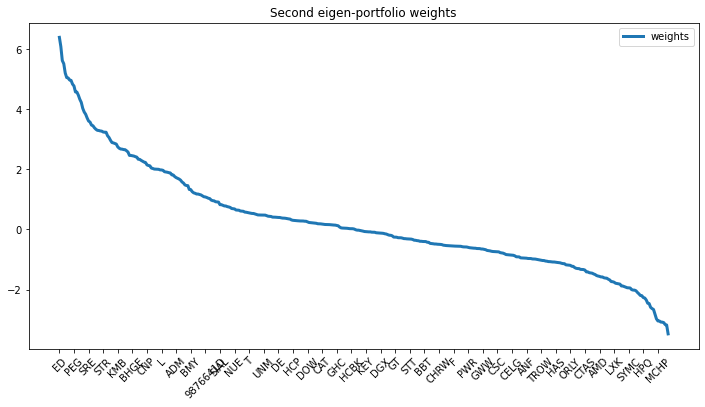

In [10]:
pc_w = np.zeros(len(stock_tickers))
eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)

if pca is not None:
    pcs = pca.components_
    
    pc_w = pcs[1]/asset_returns.std()[0:len(asset_returns.std())-1]
    pc_w = pc_w/(sum(pc_w))

    
    ### END CODE HERE ###

    eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf2.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf2))
    eigen_prtf2.plot(title='Second eigen-portfolio weights',
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

### Part 4 (Compute performance of several eigen portfolios)¶
Instructions:

. Implement sharpe_ratio() function. The function takes ts_returns argument of type pd.Series and returns a tuple of annualized return, annualized vol, and annualized sharpe ratio, where sharpe ratio is defined as annualized return divided by annualized volatility
. find portfolio (an index into sharpe_metric) that has the highest sharpe ratio

In [11]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """
    
    annualized_return = 0.
    annualized_vol = 0.
    annualized_sharpe = 0.
    
    annualized_return = sum(ts_returns.values)*(periods_per_year/len(ts_returns))
    annualized_vol = ts_returns.std()*np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return/annualized_vol
    
    return annualized_return, annualized_vol, annualized_sharpe

We compute the annualized return, volatility, and Sharpe ratio of the first two eigen portfolios.

First eigen-portfolio:
Return = 17.69%
Volatility = 13.60%
Sharpe = 1.30


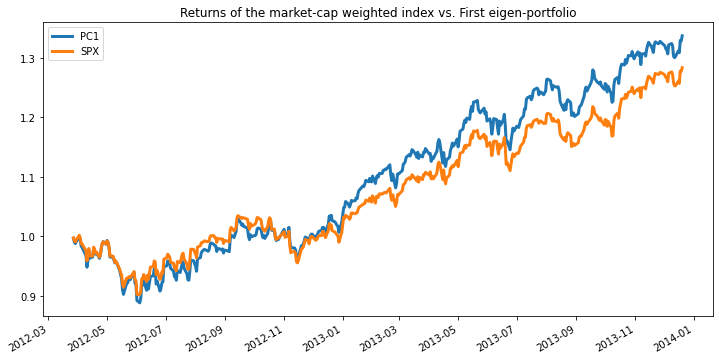

In [12]:
if df_raw_test is not None:
    eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)
    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)

Second eigen-portfolio:
Return = 4.07%
Volatility = 20.81%
Sharpe = 0.20


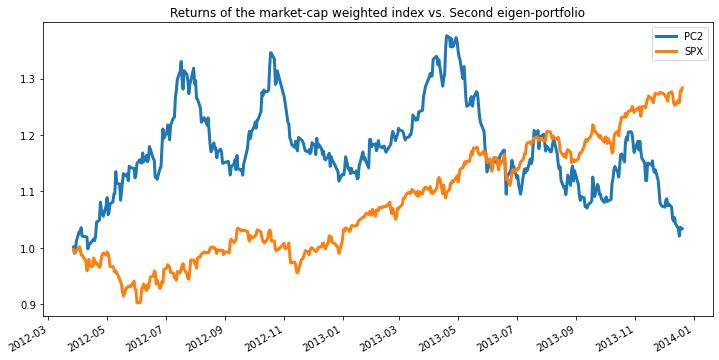

In [13]:
if df_raw_test is not None:
    eigen_prtf2_returns = np.dot(df_raw_test.loc[:, eigen_prtf2.index], eigen_prtf2 / 100)
    eigen_prtf2_returns = pd.Series(eigen_prtf2_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf2_returns)
    print('Second eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    
    year_frac = (eigen_prtf2_returns.index[-1] - eigen_prtf2_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC2': eigen_prtf2_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. Second eigen-portfolio', 
                             figsize=(12,6), linewidth=3)

We repeat the exercise of computing Sharpe ratio for the first N portfolios and select portfolio with the highest postive Sharpe ratio.

Eigen portfolio #5 with the highest Sharpe. Return 49.77%, vol = 22.45%, Sharpe = 2.22


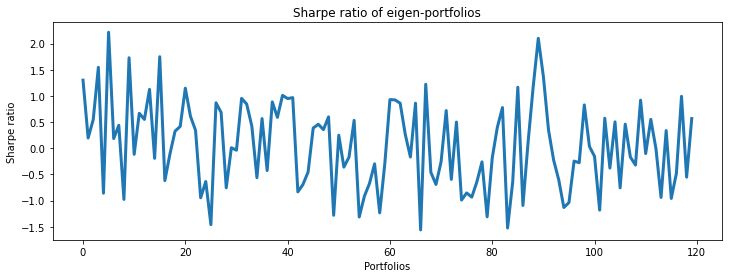

In [14]:
n_portfolios = 120
annualized_ret = np.array([0.] * n_portfolios)
sharpe_metric = np.array([0.] * n_portfolios)
annualized_vol = np.array([0.] * n_portfolios)
idx_highest_sharpe = 0 # index into sharpe_metric which identifies a portfolio with rhe highest Sharpe ratio
    
if pca is not None:
    for ix in range(n_portfolios):
        
        ### START CODE HERE ### (≈ 4-5 lines of code)
        pc_w = pcs[ix]/asset_returns.std()[0:len(asset_returns.std())-1]
        pc_w = pc_w/(sum(pc_w))
        
        eigen_prtf = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtf.sort_values(by=['weights'], ascending=False, inplace=True)
        
        eigen_prtf_returns = np.dot(df_raw_test.loc[:, eigen_prtf.index], eigen_prtf / 100)
        eigen_prtf_returns = pd.Series(eigen_prtf_returns.squeeze(), index=df_test.index)
        annualized_ret[ix], annualized_vol[ix], sharpe_metric[ix] = sharpe_ratio(eigen_prtf_returns)
        
    
        ### END CODE HERE ###
    
    
    # find portfolio with the highest Sharpe ratio
    ### START CODE HERE ### (≈ 2-3 lines of code)
        idx_highest_sharpe = sharpe_metric.argmax()
    ### ...
    
    ### END CODE HERE ###
    
    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (idx_highest_sharpe,
           annualized_ret[idx_highest_sharpe]*100, 
           annualized_vol[idx_highest_sharpe]*100, 
           sharpe_metric[idx_highest_sharpe]))

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

In [15]:
results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
results.head(10)

,Return,Vol,Sharpe
5,0.497709,0.224492,2.217044
89,1.826825,0.869346,2.101378
15,0.606838,0.346814,1.749753
9,0.457706,0.264606,1.729765
3,0.152117,0.098285,1.547712
90,6.161160,4.494235,1.370903
0,0.176938,0.135986,1.301150
67,1.084282,0.886438,1.223189
88,1.642317,1.402866,1.170687
85,1.837612,1.575897,1.166073
